## **ANALISIS DESCRIPTIVO DE LA CARTERA DE IMPUESTO DE INDUSTRIA Y COMERCIO**

**Introducción**

El presente trabajo tiene como objetivo realizar un código que permita identificar la composición de la cartera del **Impuesto de Industria y Comercio** por Vigencia (La vigencia corresponde al año en el cual se venció la cartera) con base en datos históricos desde el año 2004 hasta el 2024.

In [22]:
#Importamos librerías para el cargue de datos y posterior trabajo en el análisis descriptivo
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, year, format_number,udf
from pyspark.sql.types import StringType
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
#Creamos una sesion de Spark

spark=SparkSession.builder\
    .appName("AnalisisIndCcio")\
    .getOrCreate()        

In [15]:
#Cargue del Dataset
ruta="C:\\Users\\Mike Miranda\\OneDrive\\Documentos\\Politecnico Internacional\\7mo Sem\\Big Data II\\github\\BigDataII\\data\\indccio2024.csv"
dfindccio=spark.read.csv(ruta,header=True,sep=";")
#cambio del tipo de datos para el Valor de Cartera
dfindccio=dfindccio.withColumn("VALOR_CARTERA", col("VALOR_CARTERA").cast("double"))
dfindccio.show()

+------+--------------------+-------+--------+------------------+--------------------+-------------+
|CODIGO|              NOMBRE|PERIODO|CONCEPTO|     DESC_CONCEPTO|           DIRECCION|VALOR_CARTERA|
+------+--------------------+-------+--------+------------------+--------------------+-------------+
| 91913|    CALZADO RESTREPO|   2024|    2019|Sobretasa Bomberil|MANZANA 31 CASA 3...|      21000.0|
| 94381|     PUBLIESTAMPADOS|   2024|    2019|Sobretasa Bomberil|CARRERA 9 NRO. 28...|      21000.0|
| 51883|SERVICIO  ELECTRI...|   2024|    2019|Sobretasa Bomberil|CL  20  #  20 - 0...|      21000.0|
| 56585|     LLUVIAS DE AMOR|   2024|    2019|Sobretasa Bomberil|MZ 13 CS 150 LC 3...|      21000.0|
| 58334|    INTERCHAT.COM.CO|   2024|    2019|Sobretasa Bomberil|  CR  24  B  72 - 52|      21000.0|
| 62802|            VS SHOES|   2024|    2019|Sobretasa Bomberil|CR 8 15-20 LOCAL ...|      21000.0|
| 72814|PARQUEADERO EL PA...|   2024|    2019|Sobretasa Bomberil|          CL 17 5 48|     

In [16]:
dfindccio.printSchema()
print("Total de registros del Dataframe: ",dfindccio.count())

root
 |-- CODIGO: string (nullable = true)
 |-- NOMBRE: string (nullable = true)
 |-- PERIODO: string (nullable = true)
 |-- CONCEPTO: string (nullable = true)
 |-- DESC_CONCEPTO: string (nullable = true)
 |-- DIRECCION: string (nullable = true)
 |-- VALOR_CARTERA: double (nullable = true)

Total de registros del Dataframe:  242660


Como se puede observar, se tiene un set de datos con 7 columnas y un total de 242660 registros. la columna PERIODO hace referencia a la vigencia, mientras que la columna CONCEPTO es una codificación que obedece a cada uno de los conceptos de la cartera en mora. La descripción de cada concepto corresponde a la columna DESC_CONCEPTO, y el valor de la cartera está en la columna VALOR_CARTERA.

Para el siguiente proyecto se realizará un análisis exploratorio, para posteriormente revisar una distribución de conceptos por vigencia.

In [27]:
#Distribucion de Conceptos por vigencia

#Funcion para cambiar la presentación de los datos de la columna Cartera Total
def formatearnum(valor):
    return"{:,.2f}".format(valor) if valor is not None else None

formatearnum_udf=udf(formatearnum,StringType())

conceptos_cont = dfindccio.groupBy("DESC_CONCEPTO") \
    .agg(sum("VALOR_CARTERA").alias("Cartera Total")) \
    .orderBy("Cartera Total", ascending=False)

#Aplicar formato para separar por miles la columna Cartera Total
conceptos_cont_formateado=conceptos_cont.withColumn("Cartera Total",formatearnum_udf(col("Cartera Total")))

#Conversion del DataFrame a un DataFrame de Pandas para Mostrar los datos bajo el formato requerido
conceptos_pandas=conceptos_cont_formateado.toPandas()

pd.set_option("display.max_colwidth",None)
pd.set_option("display.max_rows",None)

print(conceptos_pandas.head(65))

                               DESC_CONCEPTO      Cartera Total
0      Sancion por Omiso Declaracion Inducom  62,656,046,530.00
1                       Industria y Comercio  19,770,557,455.00
2          Interes Mora Industria y Comercio  17,164,373,123.00
3                            Otras Sanciones   9,618,674,751.00
4                Sancion por Extemporaneidad   3,883,296,584.00
5           Anticipo de Industria y Comercio   2,023,584,991.00
6   Anticipo Interes Mora Industria y Comerc   1,965,568,413.00
7                          Avisos y Tableros   1,559,725,398.00
8              Sancion por Medios Magneticos   1,307,039,190.00
9                  Interes Avisos y Tableros   1,287,695,801.00
10                         Sancion por Firma   1,079,669,969.00
11                Interés Sobretasa Bomberil     724,663,998.00
12                        Sobretasa Bomberil     519,856,816.00
13                   Sancion por Inexactitud     442,467,646.00
14       Sancion Acuerdo 14 Derogado Ind

A través de la anterior visualización se pueden obtener los valores de cartera por cada uno de los conceptos, siendo los más altos el de "Sanción por Omiso" con $62.656 Millones, seguido del impuesto de "Industria y Comercio con $19.770 Millones y del "Interes de Mora del Impuesto de Industria y Comercio" con $17.164 Millones.

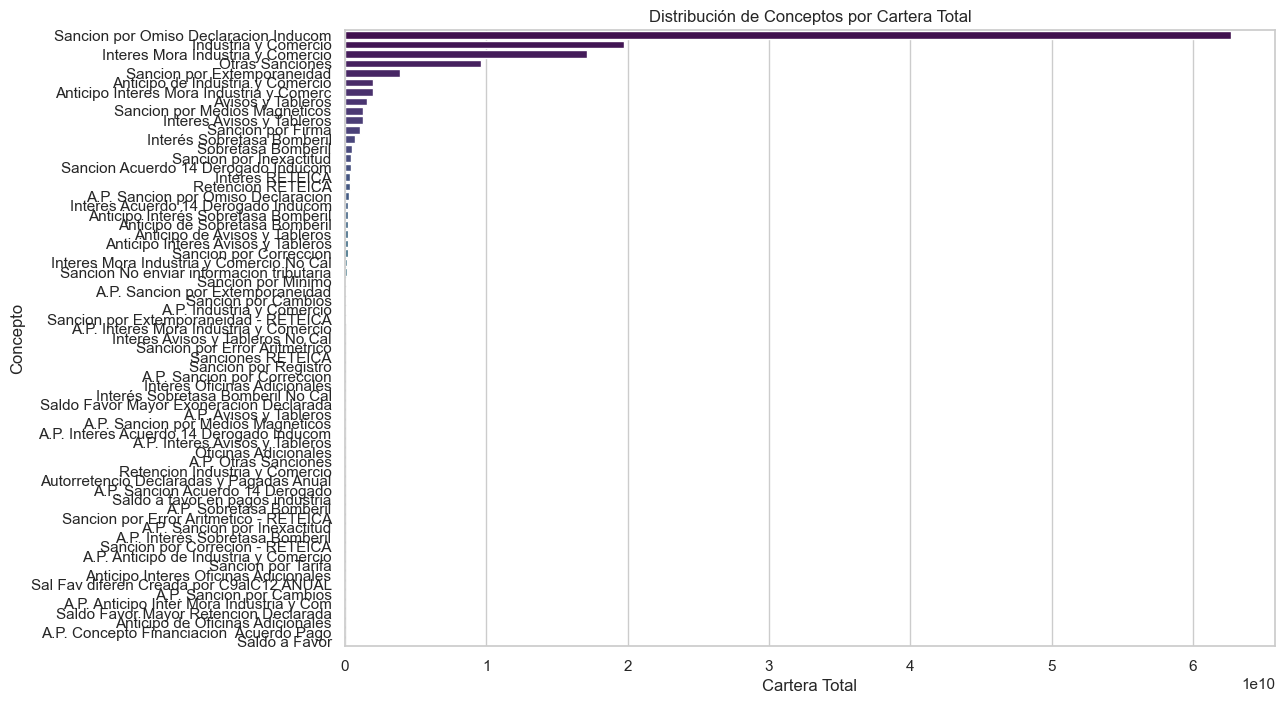

In [37]:
#Gráfica de Barras por Conceptos

#Conversion de datos de cartera total del DF de Pandas a número para que realice la suma de cartera
conceptos_pandas['Cartera Total'] = conceptos_pandas['Cartera Total'].replace({',': ''}, regex=True) 
conceptos_pandas['Cartera Total'] = pd.to_numeric(conceptos_pandas['Cartera Total'])

#Grafico de Barras 
plt.figure(figsize=(12, 8))
sns.barplot(data=conceptos_pandas, y='DESC_CONCEPTO', x='Cartera Total', palette='viridis')
plt.xlabel('Cartera Total')
plt.ylabel('Concepto')
plt.title('Distribución de Conceptos por Cartera Total')
plt.show()

Se puede visualizar que el valor más significativo para el total de conceptos se encuentra en las sanciones por omiso, el impuesto de industria y comercio, y los intereses de mora para el mismo impuesto. en adelante, los valores llegan a ser significativamente distantes de estos tres primeros mencionados.